# Matrix Multiplication

本教程使用 Triton 来实现矩阵乘法，性能可以媲美 cuBLAS。该实现是一个经典的分块计算的实现，并使用了重排的方案来提供 L2 缓存的命中率。一般来说，矩阵乘法这样的非常基础性的运算函数都是由各个硬件供应商自己完成的，一般作为所谓的 kernel libraries，比如 cuBLAS。不过这些库通常是闭源的，使用大量硬件细节相关的优化，很难让用户定制化扩展，比如我们希望将激活函数融合到矩阵乘法中。


一个矩阵乘法的分块实现的算法如下：

```python
for m in range(0, M, BLOCK_SIZE_M):
    for n in range(0, N, BLOCK_SIZE_N):
        acc = zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=float32)
        for k in range(0, K, BLOCK_SIZE_K):
            a = A[m:m+BLOCK_SIZE_M, k:k+BLOCK_SIZE_K]
            b = B[k:k+BLOCK_SIZE_K, n:n+BLOCK_SIZE_N]
            acc += dot(a, b)
        C[m:m+BLOCK_SIZE_M, n:n+BLOCK_SIZE_N] = acc
```

在我们的 Triton 实现中，在双重循环内的部分将由一个线程块（triton program）来实现，对应实现的代码是一个 kernel 函数。

## 指针运算

在 Triton 中要实现上面的计算，实际非常的简单，主要的困难在于以下两条语句中对于 A 和 B 的内存的读取：

```python
a = A[m:m+BLOCK_SIZE, k:k+BLOCK_SIZE_K]
b = B[k:k+BLOCK_SIZE_K, n:n+BLOCK_SIZE_N]
```

对于 `torch.Tensor` 结构的二维张量`X`来说，`X[i,j]`内存地址为:

```
&X[i,j] = X_ptr + i * stride[0] + j * stride[1]
```

因此对于矩阵中的一个分块子矩阵来说，我们可以通过下面的方法来取子矩阵中每个元素的地址：

```python
&A[m:m+BLOCK_SIZE_M, k:k+BLOCK_SIZE_K] = A_ptr + \
    (i:i+BLOCK_SIZE_M)[:,None] * A.stride(0) + \
    (k:k+BLOCK_SIZE_K)[None,:] * A.stride(1)
```

## L2 Cache Optimization

如果按上面伪代码的描述，我们对于输出矩阵 C 的计算是按块计算的，并且按行主序的方式进行一行一行的计算。行主序的问题是对于 L2 缓存不太友好。

例如，在以下的矩阵乘法中，每个矩阵是 9 块乘 9 块，我们可以看到，如果我们以行优先顺序计算输出，我们需要将 90 块加载到 SRAM 中以计算前 9 个输出块，但如果我们以分组顺序进行，只需加载 54 块。


<div class="wy-nav-content-img">
    <img src="assets/matrix-multiplication_l2_cache_optimization.png" width="800px" alt="L2 Cache 优化">
    <p>L2 Cache 优化</p>
</div>

在实践中，这可以在某些硬件架构上提高我们的矩阵乘法内核的性能超过 10%（例如，在 A100 上从 220 TFLOPS 提高到 245 TFLOPS）。

In [ ]:
import torch

import triton
import triton.language as tl


def get_cuda_autotune_config():
    return [
        triton.Config(
            {
                "BLOCK_SIZE_M": 128,
                "BLOCK_SIZE_N": 256,
                "BLOCK_SIZE_K": 64,
                "GROUP_SIZE_M": 8,
            },
            num_stages=3,
            num_warps=8,
        ),
        triton.Config(
            {
                "BLOCK_SIZE_M": 64,
                "BLOCK_SIZE_N": 256,
                "BLOCK_SIZE_K": 32,
                "GROUP_SIZE_M": 8,
            },
            num_stages=4,
            num_warps=4,
        ),
        triton.Config(
            {
                "BLOCK_SIZE_M": 128,
                "BLOCK_SIZE_N": 128,
                "BLOCK_SIZE_K": 32,
                "GROUP_SIZE_M": 8,
            },
            num_stages=4,
            num_warps=4,
        ),
        triton.Config(
            {
                "BLOCK_SIZE_M": 128,
                "BLOCK_SIZE_N": 64,
                "BLOCK_SIZE_K": 32,
                "GROUP_SIZE_M": 8,
            },
            num_stages=4,
            num_warps=4,
        ),
        triton.Config(
            {
                "BLOCK_SIZE_M": 64,
                "BLOCK_SIZE_N": 128,
                "BLOCK_SIZE_K": 32,
                "GROUP_SIZE_M": 8,
            },
            num_stages=4,
            num_warps=4,
        ),
        triton.Config(
            {
                "BLOCK_SIZE_M": 128,
                "BLOCK_SIZE_N": 32,
                "BLOCK_SIZE_K": 32,
                "GROUP_SIZE_M": 8,
            },
            num_stages=4,
            num_warps=4,
        ),
        triton.Config(
            {
                "BLOCK_SIZE_M": 64,
                "BLOCK_SIZE_N": 32,
                "BLOCK_SIZE_K": 32,
                "GROUP_SIZE_M": 8,
            },
            num_stages=5,
            num_warps=2,
        ),
        triton.Config(
            {
                "BLOCK_SIZE_M": 32,
                "BLOCK_SIZE_N": 64,
                "BLOCK_SIZE_K": 32,
                "GROUP_SIZE_M": 8,
            },
            num_stages=5,
            num_warps=2,
        ),
        # Good config for fp8 inputs.
        triton.Config(
            {
                "BLOCK_SIZE_M": 128,
                "BLOCK_SIZE_N": 256,
                "BLOCK_SIZE_K": 128,
                "GROUP_SIZE_M": 8,
            },
            num_stages=3,
            num_warps=8,
        ),
        triton.Config(
            {
                "BLOCK_SIZE_M": 256,
                "BLOCK_SIZE_N": 128,
                "BLOCK_SIZE_K": 128,
                "GROUP_SIZE_M": 8,
            },
            num_stages=3,
            num_warps=8,
        ),
        triton.Config(
            {
                "BLOCK_SIZE_M": 256,
                "BLOCK_SIZE_N": 64,
                "BLOCK_SIZE_K": 128,
                "GROUP_SIZE_M": 8,
            },
            num_stages=4,
            num_warps=4,
        ),
        triton.Config(
            {
                "BLOCK_SIZE_M": 64,
                "BLOCK_SIZE_N": 256,
                "BLOCK_SIZE_K": 128,
                "GROUP_SIZE_M": 8,
            },
            num_stages=4,
            num_warps=4,
        ),
        triton.Config(
            {
                "BLOCK_SIZE_M": 128,
                "BLOCK_SIZE_N": 128,
                "BLOCK_SIZE_K": 128,
                "GROUP_SIZE_M": 8,
            },
            num_stages=4,
            num_warps=4,
        ),
        triton.Config(
            {
                "BLOCK_SIZE_M": 128,
                "BLOCK_SIZE_N": 64,
                "BLOCK_SIZE_K": 64,
                "GROUP_SIZE_M": 8,
            },
            num_stages=4,
            num_warps=4,
        ),
        triton.Config(
            {
                "BLOCK_SIZE_M": 64,
                "BLOCK_SIZE_N": 128,
                "BLOCK_SIZE_K": 64,
                "GROUP_SIZE_M": 8,
            },
            num_stages=4,
            num_warps=4,
        ),
        triton.Config(
            {
                "BLOCK_SIZE_M": 128,
                "BLOCK_SIZE_N": 32,
                "BLOCK_SIZE_K": 64,
                "GROUP_SIZE_M": 8,
            },
            num_stages=4,
            num_warps=4,
        ),
    ]


def get_autotune_config():
    return get_cuda_autotune_config()


# `triton.jit`'ed functions can be auto-tuned by using the `triton.autotune` decorator, which consumes:
#   - A list of `triton.Config` objects that define different configurations of
#       meta-parameters (e.g., `BLOCK_SIZE_M`) and compilation options (e.g., `num_warps`) to try
#   - An auto-tuning *key* whose change in values will trigger evaluation of all the
#       provided configs
@triton.autotune(
    configs=get_autotune_config(),
    key=["M", "N", "K"],
)
@triton.jit
def matmul_kernel(
    # Pointers to matrices
    a_ptr,
    b_ptr,
    c_ptr,
    # Matrix dimensions
    M,
    N,
    K,
    # The stride variables represent how much to increase the ptr by when moving by 1
    # element in a particular dimension. E.g. `stride_am` is how much to increase `a_ptr`
    # by to get the element one row down (A has M rows).
    stride_am,  # A 矩阵在相邻两行(M)上 a_ptr 的移动的距离
    stride_ak,  # A 矩阵在相邻两列(K)上 a_ptr 的移动的距离
    stride_bk,  # B 矩阵在相邻两行(K)上 b_ptr 的移动的距离
    stride_bn,  # B 矩阵在相邻两列(N)上 b_ptr 的移动的距离
    stride_cm,  # C 矩阵在相邻两行(M)上 c_ptr 的移动的距离
    stride_cn,  # C 矩阵在相邻两列(N)上 c_ptr 的移动的距离
    # Meta-parameters
    BLOCK_SIZE_M: tl.constexpr,
    BLOCK_SIZE_N: tl.constexpr,
    BLOCK_SIZE_K: tl.constexpr,  #
    GROUP_SIZE_M: tl.constexpr,  #
    ACTIVATION: tl.constexpr,  #
):
    """Kernel for computing the matmul C = A x B.
    A has shape (M, K), B has shape (K, N) and C has shape (M, N)
    """
    # -----------------------------------------------------------
    # pid 为线程块（一维）的 id，每个线程块计算 C 中一个 tile 网络内的结果
    # 第一步就是计算 pid 应该映射到 C 中的哪一个 tile (二维结构) --> (pid_m, pid_n)
    # 正常来说是按 row-major 一个线程块对应一个 C 中的网络，但是由于 L2 cache Optimization 的原因
    # 会先计算 pid 在哪个 Group 中，在 group 里，按 column major 去映射
    pid = tl.program_id(axis=0)
    # C矩阵在 M 方向上有多少个格子
    num_pid_m = tl.cdiv(M, BLOCK_SIZE_M)
    # C矩阵在 N 方向上有多少个格子
    num_pid_n = tl.cdiv(N, BLOCK_SIZE_N)
    # 一个分组内有多少个线程块
    num_pid_in_group = GROUP_SIZE_M * num_pid_n
    # 计算当前线程块在哪个 group 里
    group_id = pid // num_pid_in_group
    # 当前 group 的第一个线程块对应的 M 方向的序号
    first_pid_m = group_id * GROUP_SIZE_M
    # 在接近行末的时候，对应的 group 可能不足 GROUP_SIZE_M 行
    group_size_m = min(num_pid_m - first_pid_m, GROUP_SIZE_M)

    # pid % num_pid_in_group 是当前 线程块 在 group 内的序号
    # 然后按列来 col-major 来计算对应 block 来处理的数据块
    pid_m = first_pid_m + ((pid % num_pid_in_group) % group_size_m)
    pid_n = (pid % num_pid_in_group) // group_size_m

    # ----------------------------------------------------------
    # Create pointers for the first blocks of A and B.
    # We will advance this pointer as we move in the K direction
    # and accumulate
    # `a_ptrs` is a block of [BLOCK_SIZE_M, BLOCK_SIZE_K] pointers
    # `b_ptrs` is a block of [BLOCK_SIZE_K, BLOCK_SIZE_N] pointers
    # offs_am 为在 M 方向上网格里每行元素的偏移量，超过 M 的直接取余数
    offs_am = (pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)) % M
    # offs_bm 为在 N 方向上网格里每列元素的偏移量
    offs_bn = (pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)) % N
    # offs_k 为在 K 方向上网格里每个元素的偏移量
    offs_k = tl.arange(0, BLOCK_SIZE_K)
    # a_ptrs 是 A 中第 pid_m 行格子中第一个格子中所有元素的指针
    a_ptrs = a_ptr + (offs_am[:, None] * stride_am + offs_k[None, :] * stride_ak)
    # b_ptrs 是 B 中第 pid_n 列格子中第一个格子中的所有元素的指针
    b_ptrs = b_ptr + (offs_k[:, None] * stride_bk + offs_bn[None, :] * stride_bn)

    # -----------------------------------------------------------
    # Iterate to compute a block of the C matrix.
    # We accumulate into a `[BLOCK_SIZE_M, BLOCK_SIZE_N]` block
    # of fp32 values for higher accuracy.
    # `accumulator` will be converted back to fp16 after the loop.
    accumulator = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=tl.float32)
    for k in range(0, tl.cdiv(K, BLOCK_SIZE_K)):
        # Load the next block of A and B, generate a mask by checking the K dimension.
        # If it is out of bounds, set it to 0.
        a = tl.load(a_ptrs, mask=offs_k[None, :] < K - k * BLOCK_SIZE_K, other=0.0)
        b = tl.load(b_ptrs, mask=offs_k[:, None] < K - k * BLOCK_SIZE_K, other=0.0)
        # We accumulate along the K dimension.
        accumulator = tl.dot(a, b, accumulator)
        # Advance the ptrs to the next K block.
        a_ptrs += BLOCK_SIZE_K * stride_ak  # 所有元素在 K 方向上移动一个格子
        b_ptrs += BLOCK_SIZE_K * stride_bk  # 所有元素在 K 方向上移动一个格子
    # You can fuse arbitrary activation functions here
    # while the accumulator is still in FP32!
    if ACTIVATION == "leaky_relu":
        accumulator = leaky_relu(accumulator)
    c = accumulator.to(tl.float16)

    # -----------------------------------------------------------
    # Write back the block of the output matrix C with masks.
    offs_cm = pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)
    offs_cn = pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)
    c_ptrs = c_ptr + stride_cm * offs_cm[:, None] + stride_cn * offs_cn[None, :]
    c_mask = (offs_cm[:, None] < M) & (offs_cn[None, :] < N)
    tl.store(c_ptrs, c, mask=c_mask)


# We can fuse `leaky_relu` by providing it as an `ACTIVATION` meta-parameter in `matmul_kernel`.
@triton.jit
def leaky_relu(x):
    return tl.where(x >= 0, x, 0.01 * x)


def matmul(a, b, activation=""):
    # Check constraints.
    assert a.shape[1] == b.shape[0], "Incompatible dimensions"
    assert a.is_contiguous(), "Matrix A must be contiguous"
    M, K = a.shape
    K, N = b.shape
    # Allocates output.
    c = torch.empty((M, N), device=a.device, dtype=torch.float16)
    # 1D launch kernel where each block gets its own program.
    grid = lambda META: (
        triton.cdiv(M, META["BLOCK_SIZE_M"]) * triton.cdiv(N, META["BLOCK_SIZE_N"]),
    )
    matmul_kernel[grid](
        a,
        b,
        c,  #
        M,
        N,
        K,  #
        a.stride(0),
        a.stride(1),  #
        b.stride(0),
        b.stride(1),  #
        c.stride(0),
        c.stride(1),  #
        ACTIVATION=activation,  #
    )
    return c

In [2]:
torch.manual_seed(0)
a = torch.randn((512, 512), device="cuda", dtype=torch.float16)
b = torch.randn((512, 512), device="cuda", dtype=torch.float16)

triton_output = matmul(a, b)
torch_output = torch.matmul(a, b)

# Bigger tolerance for AMD MI200 devices.
# MI200 devices use reduced precision fp16 and bf16 and flush input and
# output denormal values to zero. Detailed info is at: https://pytorch.org/docs/stable/notes/numerical_accuracy.html#reduced-precision-fp16-and-bf16-gemms-and-convolutions-on-amd-instinct-mi200-devices
rtol = 0
if torch.allclose(triton_output, torch_output, atol=1e-2, rtol=rtol):
    print("✅ Triton and Torch match")
else:
    print("❌ Triton and Torch differ")

triton_output_with_fp16_inputs=tensor([[ 35.3438,   7.3320,   0.7061,  ...,  18.5156,  14.6562, -26.2031],
        [ -5.4375,  -0.4768,  -6.5859,  ...,  -9.5156,  24.3750, -12.9375],
        [  7.9062,  36.1562, -15.8672,  ..., -13.4062,  -7.9727,  -3.3281],
        ...,
        [  4.9766, -24.0938, -19.5781,  ...,  30.1875, -25.8750,  -8.2109],
        [-22.6406,   0.2034, -11.8984,  ..., -18.6094,  37.5000,  -6.7266],
        [ 55.0000,  11.8281, -40.3125,  ..., -18.8438,  34.3750, -38.6875]],
       device='cuda:0', dtype=torch.float16)
torch_output_with_fp16_inputs=tensor([[ 35.3438,   7.3320,   0.7061,  ...,  18.5156,  14.6562, -26.2031],
        [ -5.4375,  -0.4768,  -6.5859,  ...,  -9.5156,  24.3750, -12.9375],
        [  7.9062,  36.1562, -15.8672,  ..., -13.4062,  -7.9727,  -3.3281],
        ...,
        [  4.9766, -24.0938, -19.5781,  ...,  30.1875, -25.8750,  -8.2109],
        [-22.6406,   0.2034, -11.8984,  ..., -18.6094,  37.5000,  -6.7266],
        [ 55.0000,  11.8281, -4

In [3]:
TORCH_HAS_FP8 = hasattr(torch, "float8_e5m2")
if TORCH_HAS_FP8:
    torch.manual_seed(0)
    a = torch.randn((512, 512), device="cuda", dtype=torch.float16)
    b = torch.randn((512, 512), device="cuda", dtype=torch.float16)
    a = a.to(torch.float8_e5m2)
    # pre-transpose b for efficiency.
    b = b.T
    b = b.to(torch.float8_e5m2)
    triton_output = matmul(a, b)
    torch_output = torch.matmul(a.to(torch.float16), b.to(torch.float16))

    if torch.allclose(triton_output, torch_output, atol=0.125, rtol=0):
        print("✅ Triton and Torch match")
    else:
        print("❌ Triton and Torch differ")

triton_output_with_fp8_inputs=tensor([[ -4.0703,  -3.5410,  54.1562,  ..., -14.3281, -38.9062,  -7.2031],
        [ -8.0000,   8.3281,   3.0781,  ...,  10.2266,  19.4375,  16.5781],
        [ 10.9219,  15.7578,  -9.8828,  ...,  37.3125,  -8.7188, -15.3125],
        ...,
        [-20.0469,   0.3369,  36.7188,  ..., -12.8750, -24.8125,   3.5332],
        [ -0.3115, -41.5625, -25.2188,  ...,  14.2891,  -7.0898, -31.4844],
        [-22.1719, -10.0469,   1.9580,  ..., -15.9297,  17.4062,   7.3711]],
       device='cuda:0', dtype=torch.float16)
torch_output_with_fp8_inputs=tensor([[ -4.0703,  -3.5410,  54.1562,  ..., -14.3281, -38.9062,  -7.2031],
        [ -8.0000,   8.3281,   3.0781,  ...,  10.2266,  19.4375,  16.5781],
        [ 10.9219,  15.7578,  -9.8828,  ...,  37.3125,  -8.7188, -15.3125],
        ...,
        [-20.0469,   0.3369,  36.7188,  ..., -12.8750, -24.8125,   3.5332],
        [ -0.3115, -41.5625, -25.2188,  ...,  14.2891,  -7.0898, -31.4844],
        [-22.1719, -10.0469,   1.

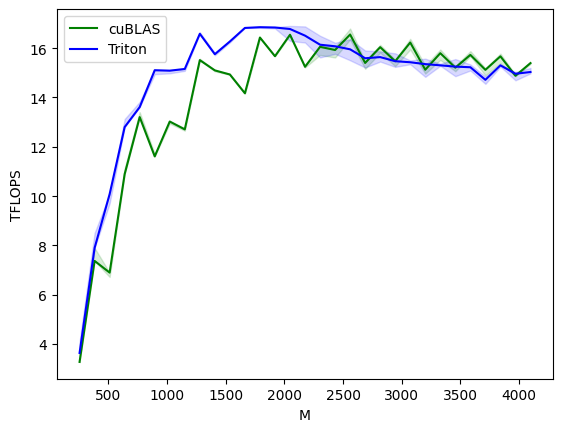

matmul-performance-fp16:
         M       N       K     cuBLAS     Triton
0    256.0   256.0   256.0   3.276800   3.640889
1    384.0   384.0   384.0   7.372800   7.899428
2    512.0   512.0   512.0   6.898527  10.082462
3    640.0   640.0   640.0  10.893617  12.800000
4    768.0   768.0   768.0  13.205015  13.611323
5    896.0   896.0   896.0  11.610975  15.106752
6   1024.0  1024.0  1024.0  13.025789  15.087425
7   1152.0  1152.0  1152.0  12.706315  15.157279
8   1280.0  1280.0  1280.0  15.515151  16.582997
9   1408.0  1408.0  1408.0  15.099258  15.756579
10  1536.0  1536.0  1536.0  14.932253  16.271007
11  1664.0  1664.0  1664.0  14.171515  16.820396
12  1792.0  1792.0  1792.0  16.431906  16.850710
13  1920.0  1920.0  1920.0  15.673469  16.838002
14  2048.0  2048.0  2048.0  16.544557  16.777215
15  2176.0  2176.0  2176.0  15.245187  16.508325
16  2304.0  2304.0  2304.0  16.053677  16.140454
17  2432.0  2432.0  2432.0  15.926566  16.076658
18  2560.0  2560.0  2560.0  16.553675  15.95

<Figure size 640x480 with 0 Axes>

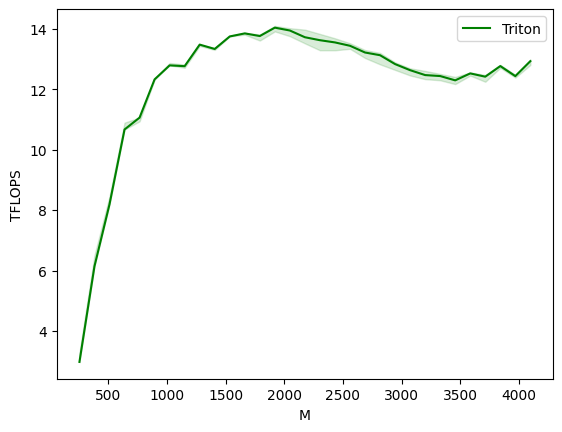

matmul-performance-fp8:
         M       N       K     Triton
0    256.0   256.0   256.0   2.978909
1    384.0   384.0   384.0   6.144000
2    512.0   512.0   512.0   8.192000
3    640.0   640.0   640.0  10.666666
4    768.0   768.0   768.0  11.059200
5    896.0   896.0   896.0  12.323930
6   1024.0  1024.0  1024.0  12.787512
7   1152.0  1152.0  1152.0  12.760615
8   1280.0  1280.0  1280.0  13.473685
9   1408.0  1408.0  1408.0  13.329526
10  1536.0  1536.0  1536.0  13.743471
11  1664.0  1664.0  1664.0  13.844480
12  1792.0  1792.0  1792.0  13.756945
13  1920.0  1920.0  1920.0  14.034517
14  2048.0  2048.0  2048.0  13.939811
15  2176.0  2176.0  2176.0  13.717552
16  2304.0  2304.0  2304.0  13.619083
17  2432.0  2432.0  2432.0  13.546029
18  2560.0  2560.0  2560.0  13.435015
19  2688.0  2688.0  2688.0  13.212489
20  2816.0  2816.0  2816.0  13.122975
21  2944.0  2944.0  2944.0  12.829459
22  3072.0  3072.0  3072.0  12.627812
23  3200.0  3200.0  3200.0  12.465914
24  3328.0  3328.0  3328.0

<Figure size 640x480 with 0 Axes>

In [4]:
configs = []
for fp8_inputs in [False, True]:
    if fp8_inputs and not TORCH_HAS_FP8:
        continue
    configs.append(
        triton.testing.Benchmark(
            x_names=["M", "N", "K"],  # Argument names to use as an x-axis for the plot
            x_vals=[
                128 * i for i in range(2, 33)
            ],  # Different possible values for `x_name`
            line_arg="provider",  # Argument name whose value corresponds to a different line in the plot
            # Possible values for `line_arg`
            # Don't compare to cublas for fp8 cases as torch.matmul doesn't support fp8 at the moment.
            line_vals=(
                ["triton"] if fp8_inputs else ["cuBLAS", "triton"]
            ),  # Label name for the lines
            line_names=(
                ["Triton"] if fp8_inputs else ["cuBLAS", "Triton"]
            ),  # Line styles
            styles=[("green", "-"), ("blue", "-")],
            ylabel="TFLOPS",  # Label name for the y-axis
            plot_name="matmul-performance-"
            + (
                "fp16" if not fp8_inputs else "fp8"
            ),  # Name for the plot, used also as a file name for saving the plot.
            args={"fp8_inputs": fp8_inputs},
        )
    )


@triton.testing.perf_report(configs)
def benchmark(M, N, K, provider, fp8_inputs):
    a = torch.randn((M, K), device="cuda", dtype=torch.float16)
    b = torch.randn((K, N), device="cuda", dtype=torch.float16)
    if TORCH_HAS_FP8 and fp8_inputs:
        a = a.to(torch.float8_e5m2)
        b = b.T
        b = b.to(torch.float8_e5m2)
    quantiles = [0.5, 0.2, 0.8]
    if provider == "cuBLAS":
        ms, min_ms, max_ms = triton.testing.do_bench(
            lambda: torch.matmul(a, b), quantiles=quantiles
        )
    if provider == "triton":
        ms, min_ms, max_ms = triton.testing.do_bench(
            lambda: matmul(a, b), quantiles=quantiles
        )
    perf = lambda ms: 2 * M * N * K * 1e-12 / (ms * 1e-3)
    return perf(ms), perf(max_ms), perf(min_ms)


benchmark.run(show_plots=True, print_data=True, save_path="./benchmark")